# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 2 - Segmentation
---

### <a style='color:red'> Due Date: 14/12/2022  </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).

### <img src="https://img.icons8.com/cute-clipart/64/000000/youtube.png" style="height:50px;display:inline"> Video Submission (YouTube - Optional)
---
* In this exercise you are going to produce a video.
* In addition to submiting this video in the `\output` folder (**MANDATORY**), we are also giving you the option to upload it to YouTube and submit the link in a different section on the website (just below the original submission section).
    * This will benefit you when you explain your expertise in Computer Vision (e.g., in a job interview).
    * We also may make something nice with your works at the end of the course.
* If you don't want to make your video public, you can change its visibility to "Unlisted", and then it can only be accessed via link:

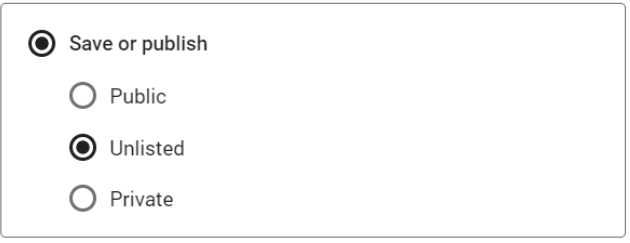

* Finally, submit the link on the course website and answer if you are okay with making this video public:

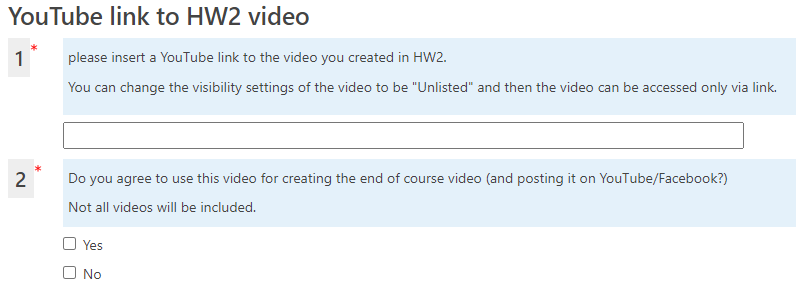


### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tf

import time

from PIL import Image
import cv2
import glob
import sklearn
import json
from urllib.request import urlopen

from os import chdir as cd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

C:\Users\USER\anaconda3\envs\anat_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Part 1 - Classic Vs. Deep Learning-based Semantic Segmentation
---
In this part you are going to compare classic methods for segmentation to deep learning-based methods. 

1. Load the images in the `./data/frogs` and `./data/horses` folders and display them.
2. Pick 1 classic method for segmentation and 1 deep learning-based method and segment the given images. Display the results.
    * **Briefly** summarize each method you picked and discuss the advantages and disadvantages of each method. In your answer, relate to the results you received in this section.
    * You can use a ready implementation from the internet or OpenCV, no need to implement it yourselves.
    * Note: the classic method **must not** use any neural network.
3. Pick 3 images (download from the internet or take them yourself) that satisfy the following, and dispaly them:
    * One image of a living being (human, animal,...).
    * One image of commonly-used object (car, chair, smartphone, glasses,...).
    * One image of not-so-commonly-used object (fire extinguisher, satellite,... **BE CREATIVE**).
4. Apply each method (one classic and one deep learning-based) on the 3 images. Display the results (mask and segmented image).
    * Which method performed better on each image? Describe your thoughts on why one method is better than the other.
    * For the classic method you can change parameters per-image, document them in the report.
    * You can add manual post-processing to get a mask if needed. If you do that, document in your report "how hard" you had to work in the post-processing stage, as it's an indication of the quality of the method.
5. As you probably have noticed, segmentation can be rough around the edges, i.e., the mask is not perfect and may be noisy around the edges. What can be done to fix or at least alleviate this problem? Your suggestions can be in pre-processing, inside the segmentation algorithm or in post-processing.

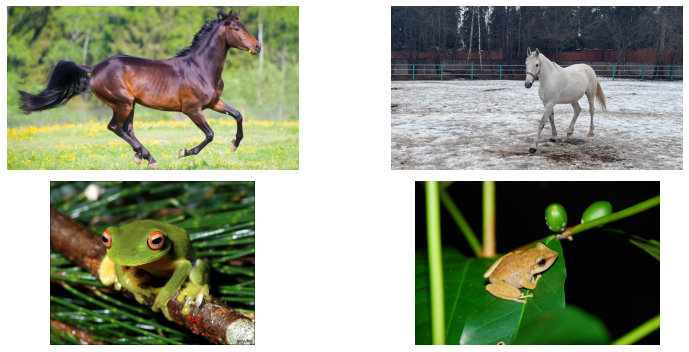

In [2]:
def load_images (path):
    images_local = [cv2.imread(file,) for file in glob.glob(path)]
    images_local = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images_local]
    return images_local

def show_images (images_list, shape_to_print, fig_size):
    fig = plt.figure(figsize = fig_size)
    a,b = shape_to_print
    for i in range(len(images_list)):
        ax = fig.add_subplot(a,b,i+1)
        ax.imshow(images_list[i])
        ax.set_axis_off()
    plt.tight_layout()
    

horses, frogs = load_images("./data/horses/*") ,load_images("./data/frogs/*")
images = horses + frogs
show_images(images,(2,2),(12,5))

In [3]:
def classic_segmentation(images: list, rectangles: list, plot_image=True):
  masks, final_images = [], []
  for img, rect in zip(images, rectangles): 
    img = np.array(img)
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]

    kernel = np.ones((3, 3), np.uint8)
    mask2 = cv2.erode(mask2, kernel)
    img = cv2.erode(img, kernel)
    masks.append(mask2)
    final_images.append(img)
    if plot_image:
      plt.figure(figsize=(15,25))
      plt.subplot(1,2,1)
      plt.imshow(img)
      plt.subplot(1,2,2)
      plt.imshow(mask2)
      plt.show()

  return masks, final_images

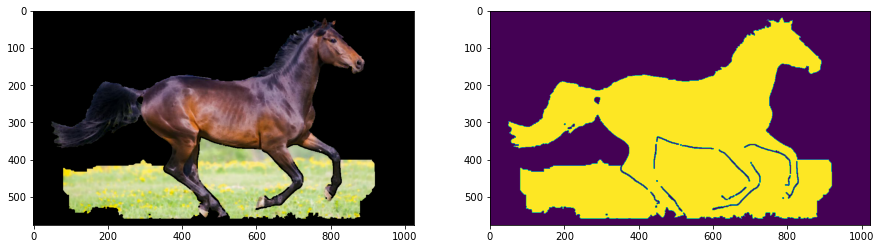

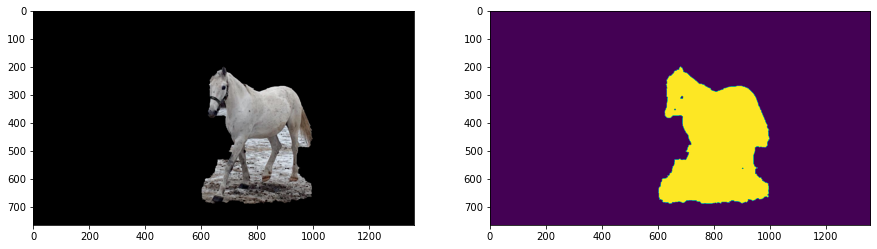

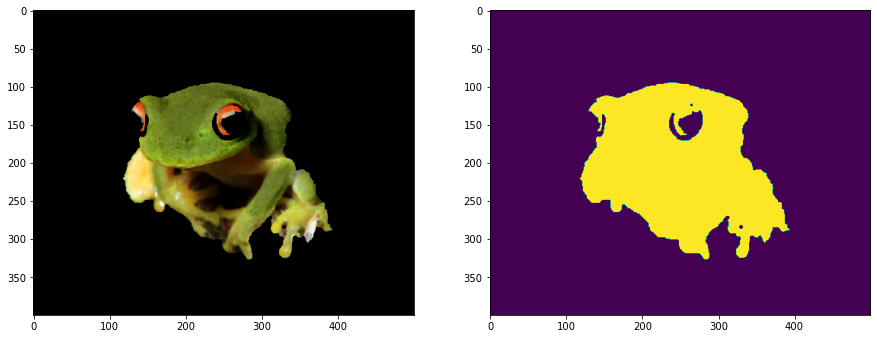

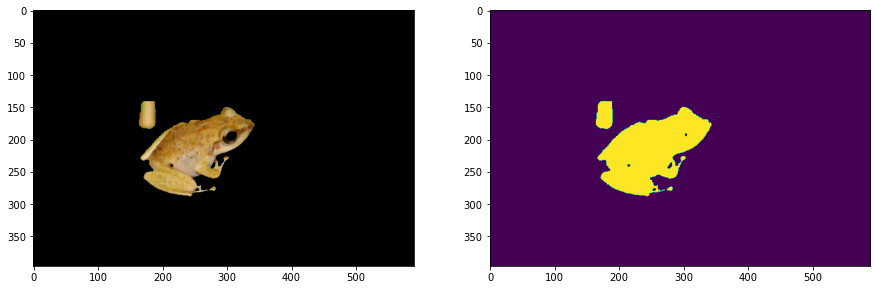

In [4]:
objects_rectangle = [(20,20,900,540),
    (600,200,400,490),
                    (80,80,320,250),
                    (150,140,240,150),
]
classic_masks, classic_images = classic_segmentation(images, objects_rectangle)

In [5]:
deeplabv3_resnet101_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
deeplabv3_resnet101_model.eval();

def Deep_segmentation(images, model=deeplabv3_resnet101_model, plot_image=True):
  masks, final_images = [], []
  for image in images:

    preprocess = tf.Compose([
        tf.ToTensor(),
        tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)

    # forward pass
    with torch.no_grad():
        output = model(input_batch)['out'][0]  # first image in batch
    output_predictions = output.argmax(0)
    print("output shape: ", output.shape)
    print("output_predictions shape: ", output_predictions.shape)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    # plot the semantic segmentation predictions of 21 classes in each color
    mask = Image.fromarray(output_predictions.byte().cpu().numpy())
    mask.putpalette(colors)
    masks.append(mask)
    final_images.append(output_predictions)
    # plot
    if plot_image:
      plt.figure(figsize=(15,25))
      plt.subplot(1,2,1)
      plt.imshow(image)
      plt.subplot(1,2,2)
      plt.imshow(mask)
      plt.show()
  return masks, final_images

Using cache found in C:\Users\USER/.cache\torch\hub\pytorch_vision_v0.10.0


output shape:  torch.Size([21, 576, 1024])
output_predictions shape:  torch.Size([576, 1024])


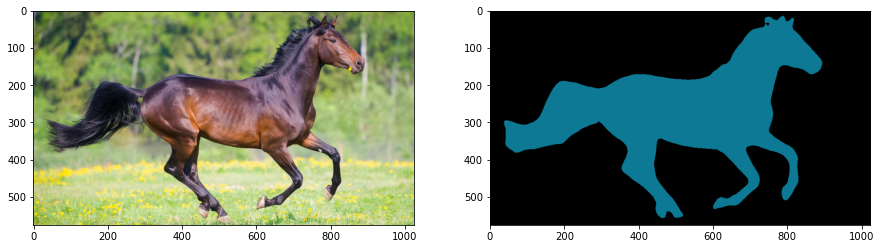

output shape:  torch.Size([21, 765, 1360])
output_predictions shape:  torch.Size([765, 1360])


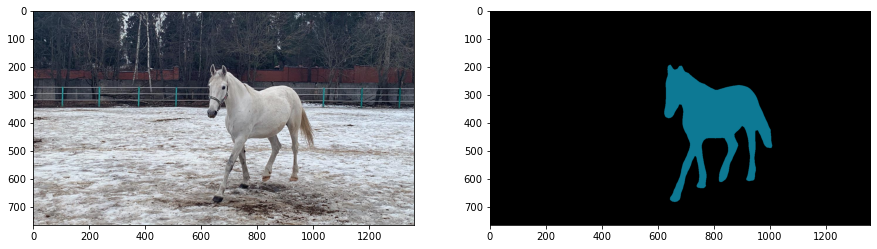

output shape:  torch.Size([21, 400, 500])
output_predictions shape:  torch.Size([400, 500])


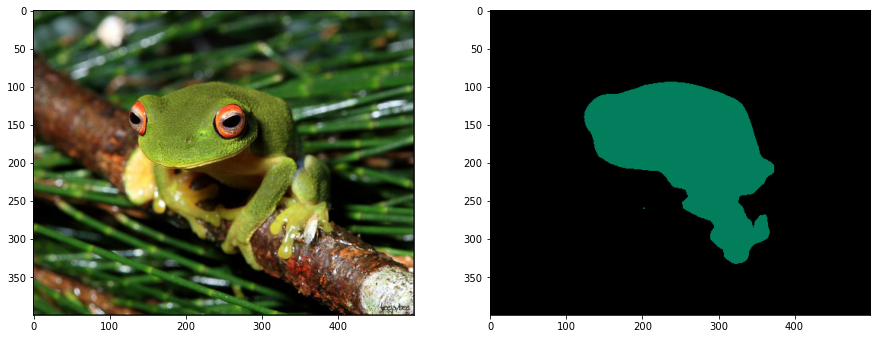

output shape:  torch.Size([21, 396, 590])
output_predictions shape:  torch.Size([396, 590])


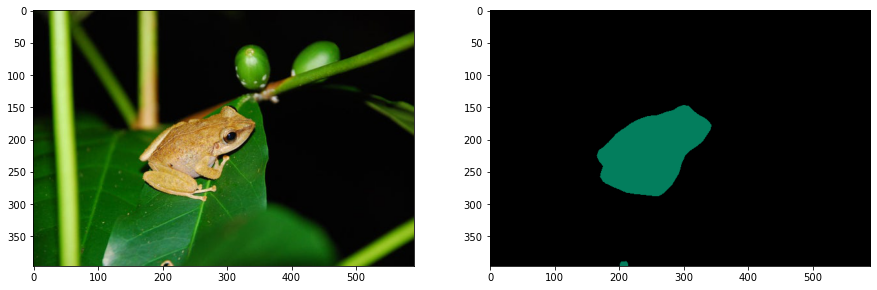

In [6]:
horses_masks, horses_seg_images = Deep_segmentation(horses)
frog_masks, frogs_seg_images = Deep_segmentation(frogs)

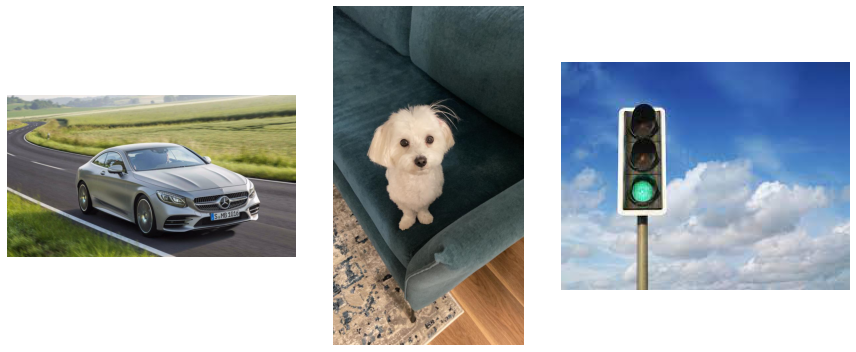

In [7]:
images_3 = load_images("./data/my_data/ex1/*")
show_images(images_3,(1,3),(12,5))

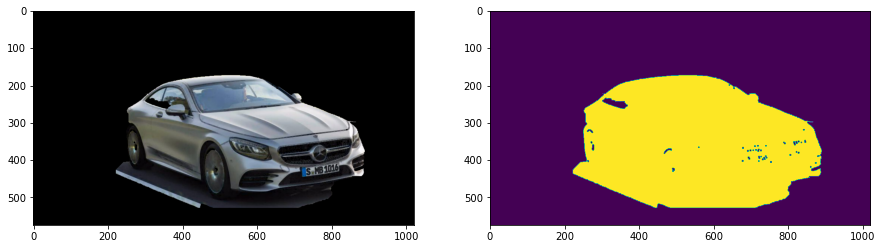

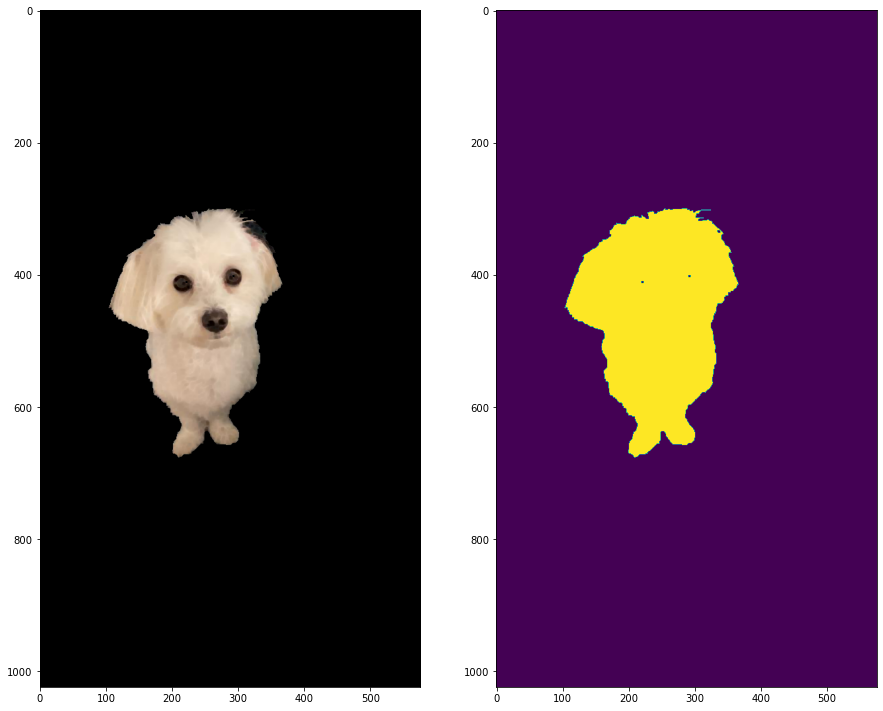

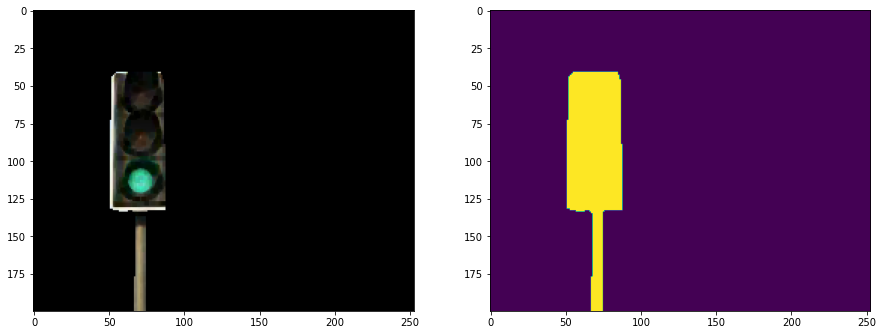

In [8]:
objects_rectangle = [(220,170,670,359),
    (80,281,360,420),
                    (40,40,50,160),
]
classic_masks, classic_images = classic_segmentation(images_3, objects_rectangle)

output shape:  torch.Size([21, 574, 1021])
output_predictions shape:  torch.Size([574, 1021])


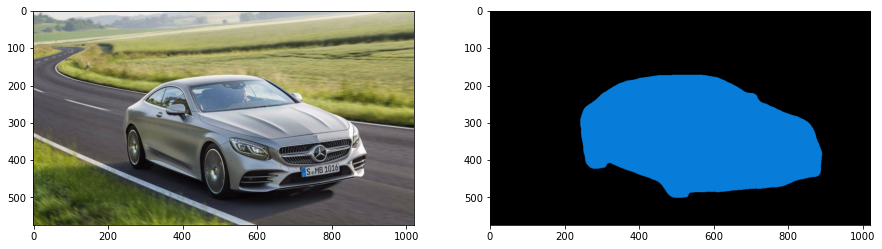

output shape:  torch.Size([21, 1024, 576])
output_predictions shape:  torch.Size([1024, 576])


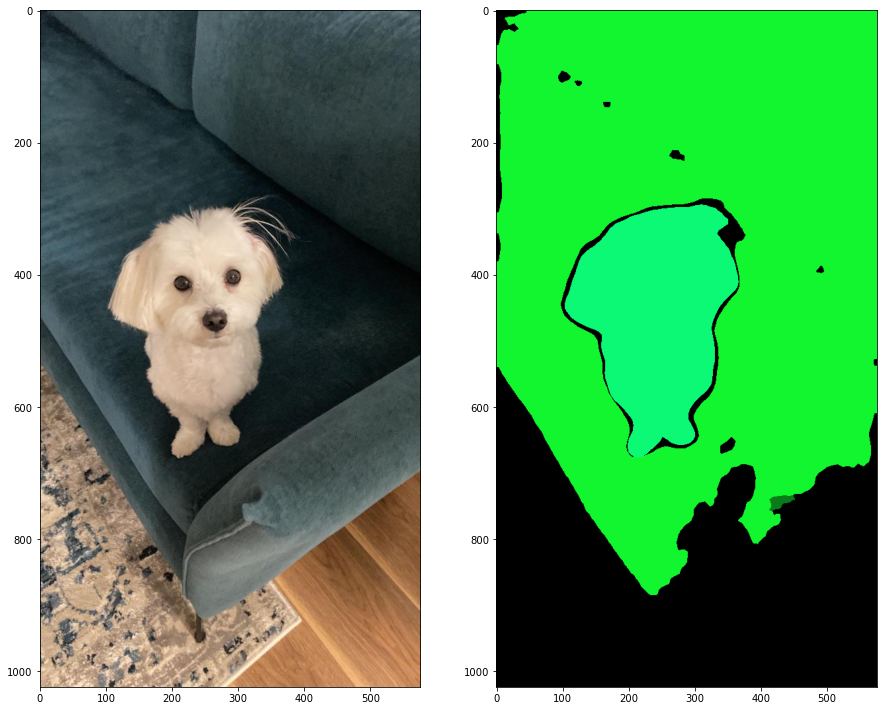

output shape:  torch.Size([21, 200, 253])
output_predictions shape:  torch.Size([200, 253])


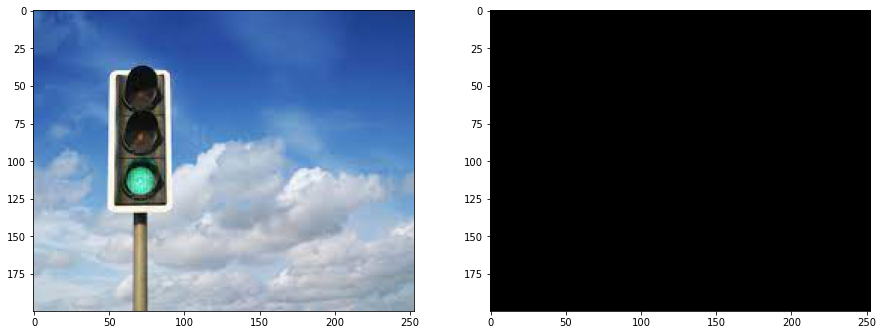

In [9]:
objects_masks, objects_seg_images = Deep_segmentation(images_3)

#### Part 2 - Adversarial Images
---
Adversarial examples are specialised images created with the purpose of confusing a neural network, resulting in the misclassification of a given input. In this exercise you are going to create an adversarial images first by using augmentations and then by using segmentation.

1. Load a pre-trained classifier (which was trained on ImageNet) from: https://pytorch.org/vision/stable/models.html#classification
. In HW1 you used VGG16, but you can choose a different classifier for this assignment.
2. Pick an image of an animal in its natural habitat (e.g., cow on grass fields, zebra in the safari etc. You can also use the supplied ./data/cow.jpg or ./data/sheep.jpg ).
Display the image you chose and feedforward it to the pre-trained network. What is the network's prediction? To convert from class index to label, use the supplied
./data/imagenet1000_clsidx_to_labels.txt file.
3. Apply the following 3 transformations to create 3 *new* images from the image from section 2, and display them (`openCV` has functions for all):
    * One **geometric transformation** (rotation, scaling, translation, warping...).
    * One **color transformation** (thresholding, different color space, hue, saturation, brightness, contrast...).
    * One **filter** (any filter you want).
4. Feed the transformed images to network, what is the output? is it different from section 2? Discuss the reasons for that to happen.
5. Segment the animal from the image in section 2, using classic or deep segmentation method. Display the result.
6. Put the animal in a different habitat, i.e., use the segmentation mask to place the animal on a different background. You can choose any background you want (which is not the animal's natural habitat). For example, put the bird on the moon or the cow on a beach (You can use the supplied ./data/background images). Display the result.
  * You should submit the final image in the `./output` folder.
  * It's encouraged to make the homework checker laugh.
7. Feed the new image to the classifier, what is the output? is it different from section 2? Discuss the reasons for that to happen.

In [14]:
import torchvision.transforms as transforms

In [10]:
# load pretrained vgg16
classifer = torchvision.models.vgg16(pretrained=True, progress=True)
classifer.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:13<00:00, 7.50MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# load sheep image
sheep_path = os.path.join("data", "sheep.jpg")
sheep_img = Image.open(sheep_path)
sheep_img.show()

In [15]:
# feed to the network
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))])

x = torch.unsqueeze(transform(sheep_img), 0)
y = torch.argmax(classifer(x))
print(y) # 348: 'ram, tup',

tensor(348)


In [16]:
# apply geometric transformation
rotated_sheep = transforms.functional.rotate(sheep_img, angle=31)
rotated_sheep.show()

x = torch.unsqueeze(transform(rotated_sheep), 0)
y = torch.argmax(classifer(x))
print(y) # 999: 'toilet tissue, toilet paper, bathroom tissue'

tensor(999)


In [17]:
# apply color transformation
color_sheep = transforms.functional.adjust_gamma(sheep_img, 0.3)
color_sheep.show()

x = torch.unsqueeze(transform(color_sheep), 0)
y = torch.argmax(classifer(x))
print(y) #  132: 'American egret, great white heron, Egretta albus',

tensor(132)


In [18]:
# apply filter
blurred_sheep = transforms.functional.gaussian_blur(sheep_img, (5, 5), sigma=5)
blurred_sheep.show()

x = torch.unsqueeze(transform(blurred_sheep), 0)
y = torch.argmax(classifer(x))
print(y) #  132: 'American egret, great white heron, Egretta albus',

tensor(132)


In [19]:
# load deeplab model
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
# put in inference mode
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to C:\Users\USER/.cache\torch\hub\v0.5.0.zip


HTTPError: HTTP Error 300: Multiple Choices

[ 0 17]


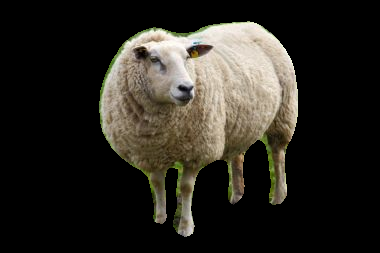

In [ ]:
# segment sheep
input_batch = torch.unsqueeze(transforms.functional.to_tensor(sheep_img), 0)


model = model.to(device)
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)['out'][0]

output_predictions = output.argmax(0)
print(np.unique(output_predictions.cpu().numpy()))

mask = torch.zeros_like(output_predictions).float().to(device)
mask[output_predictions == 17] = 1 # 17 is sheep
masked_img = sheep_img * mask.unsqueeze(2).byte().cpu().numpy()
masked_img = Image.fromarray(masked_img.astype('uint8'), 'RGB')
masked_img.show()

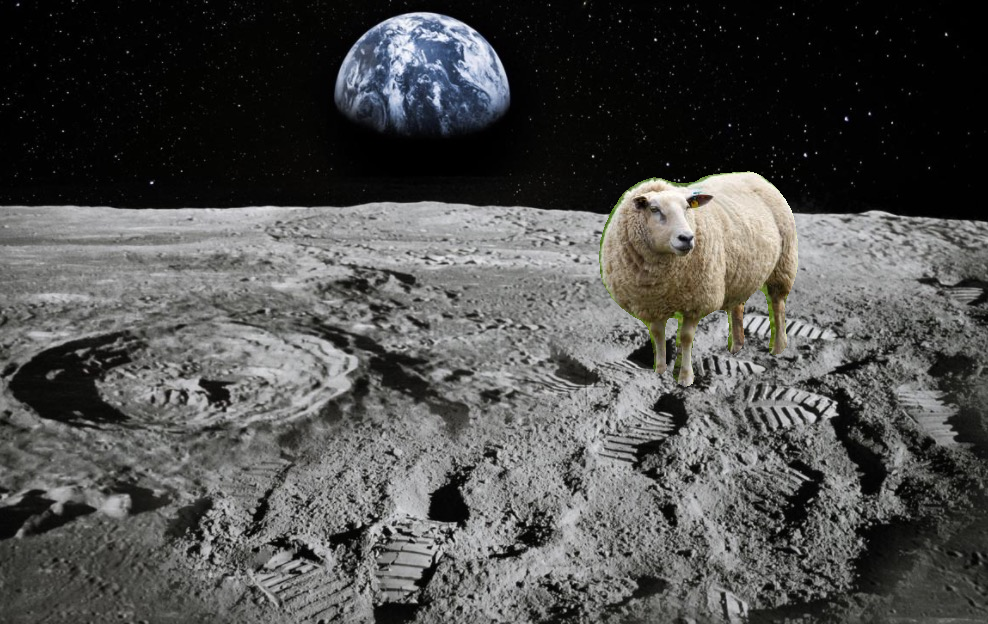

In [ ]:
# place sheep on the moon
bg_img = Image.open(os.path.join("data", "background", "moon.jpg"))
bg_img.paste(sheep_img, (500, 150), transforms.functional.to_pil_image(mask))
space_sheep = bg_img.copy()
space_sheep.show()
space_sheep.save(os.path.join("output", "space_sheep.jpg"))

In [ ]:
# classify spacesheep

x = torch.unsqueeze(transform(space_sheep), 0)
y = torch.argmax(classifer(x))
print(y) #   296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',

tensor(296)


#### Part 3 - Jurrasic Fishbach
---
In this part you are going to apply segmentation on a video, and integrate with other elements.

<img src="https://lh3.googleusercontent.com/5zF16wl-tdE1FZCuVsrNxHWzfa6uXo4hYE_BGabKnGovw2W-bIT9gnZlAgU8nUoK=w412-h220-rw">

1. Film a short video of yourself (you can use your phone for that), but without too much camera movement. You on the other hand, can move however you want (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution (lower than 720p ~ 1280x720 pixles). You can use the function in `./code/frame_video_convert.py` to help you. Display 2 frames in the report.
2. Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report.
3. Pick one of the objects in the supplied videos file (`./data/video_models`), convert it to images and segement it out using one of the methods from Part 1(classic or deep). Display 2 frames in the report. You can choose another object from: https://pixabay.com/videos/search/green%20screen/.
    * Explain how you performed the sementation for this specific type of video (i.e., green-screen videos). Did you  use a simple/classic method? Deep method? Combined both?
4. Put it all together - pick a background, put yourself and the segemented object on the background. Stich it frame-by-frame (don't make the video too long or it will take a lot of time, 10secs maximum). Display 2 frames of the result in your report. Convert the frames back to video. You can use the function in `frame_video_convert.py` to help you.
    * Tip: To make it look good, you can resize the images, create a mapping from pixel locations in the original image to pixels locations in the new image.
    * You should submit the final video in the `./output` folder (**MANDATORY**), and upload it to YouTube (**OPTIONAL**) as instructed above.
    * We expect some creative results, this can benefit you a lot when you want to demonstrate your Computer Vision abilities.

In [ ]:
import glob
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import torchvision.transforms as transforms
from frame_video_convert import video_to_image_seq, image_seq_to_video

In [ ]:
# load pre-trained deeplabv3
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
# put in inference mode
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {}".format(device))


Using cache found in /home/ronbenc/.cache/torch/hub/pytorch_vision_v0.5.0


using cpu


49
(630, 480)


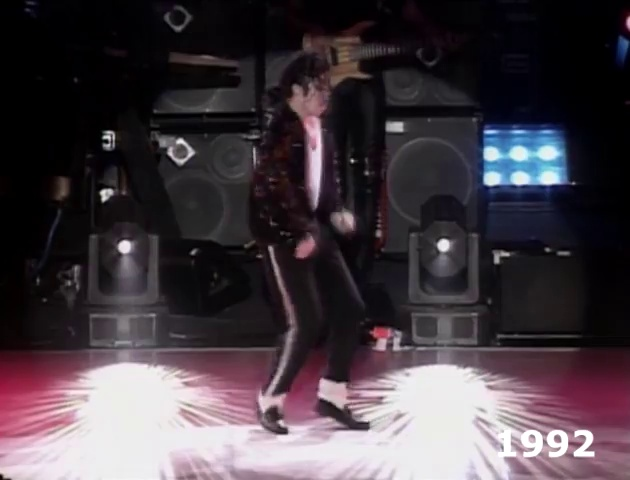

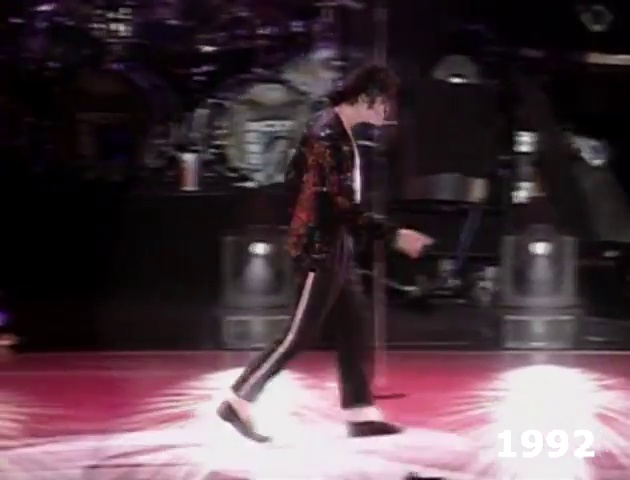

In [ ]:
# load MJ images
MJ_vid_path = os.path.join("data", "my_data", "MJ_moonwalk.mp4")
MJ_images_path = os.path.join("data", "my_data", "MJ_images")
if not os.path.exists(MJ_images_path):
    video_to_image_seq(MJ_vid_path, MJ_images_path)

MJ_images = [Image.open(file) for file in glob.glob(os.path.join(MJ_images_path, "*"))]
print(len(MJ_images))
print(MJ_images[0].size)
MJ_images[0].show()
MJ_images[48].show()

In [ ]:
def segment_person(model, input_image):
    preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # perform pre-processing
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)

    # forward pass
    with torch.no_grad():
        output = model(input_batch)['out'][0]  # first image in batch
    output_predictions = output.argmax(0)

    # what labels were recognized?
    # print(np.unique(output_predictions.cpu().numpy()))

    # create a mask
    mask = torch.zeros_like(output_predictions).float().cpu()
    mask[output_predictions == 15] = 1 # 15 is person
    masked_img = input_image * mask.unsqueeze(2).byte().cpu().numpy()
    
    return masked_img, mask


In [ ]:
# load dinosaur images

dino_vid_path = os.path.join("data", "video_models", "dinosaur_model.mp4")
dino_images_path = os.path.join("data", "my_data", "dinosaur_images")
if not os.path.exists(dino_images_path):
    video_to_image_seq(dino_vid_path, dino_images_path)

dino_images = [Image.open(file) for file in glob.glob(os.path.join(dino_images_path, "*"))]

In [ ]:
def remove_green_background(img, background = 0):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    a_channel = lab[:,:,1]
    _, mask = cv2.threshold(a_channel,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    foreground = cv2.bitwise_and(img, img, mask = mask)
    foreground[mask == 0] = background
    return foreground, mask

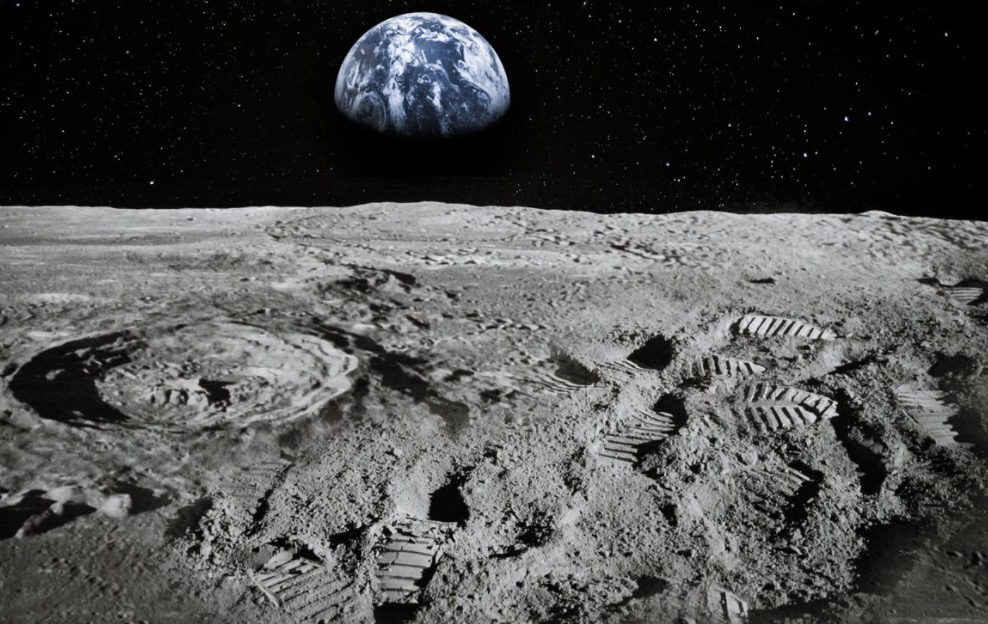

In [ ]:
# load background 
bg_img = Image.open(os.path.join("data", "background", "moon.jpg"))
bg_img.show()

In [ ]:
# make video of MJ and dino on the moon

dino_images = dino_images[ 120 -len(MJ_images):120]
segmented_MJ, segmented_dino, video_frames = [], [], []
t = transforms.ToPILImage()
for dino_img, MJ_img in zip(dino_images, MJ_images):
    frame = bg_img.copy()  
    # paste dino image
    w, h = dino_img.size
    w, h = int(w/2), int(h/2)
    dino_img = dino_img.resize((w, h))
    fg_dino, mask = remove_green_background(np.array(dino_img))
    fg_dino = Image.fromarray(np.uint8(fg_dino)).convert('RGB')
    segmented_dino.append(fg_dino)
    mask = Image.fromarray(np.uint8(mask))
    frame.paste(fg_dino, mask=mask)
    
    # paste MJ image
    w, h = MJ_img.size
    w, h = int(w/3), int(h/3)
    fg_MJ, mask = segment_person(model, MJ_img)
    fg_MJ = t(fg_MJ)
    segmented_MJ.append(fg_MJ)
    mask = t(mask)
    frame.paste(fg_MJ, (550, 100), mask=mask)
    
    video_frames.append(np.array(frame))
    



In [ ]:
# Save images
output_path = os.path.join("data", "my_data", "moon_dino_MJ")
os.makedirs(output_path, exist_ok=True)
for count, frame in enumerate(video_frames):
    image = np.array(frame)
    fname = str(count).zfill(3)
    cv2.imwrite(os.path.join(output_path, fname + ".jpg"), cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

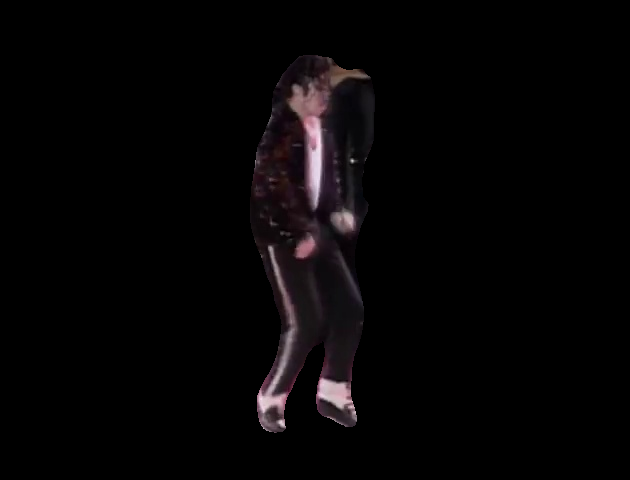

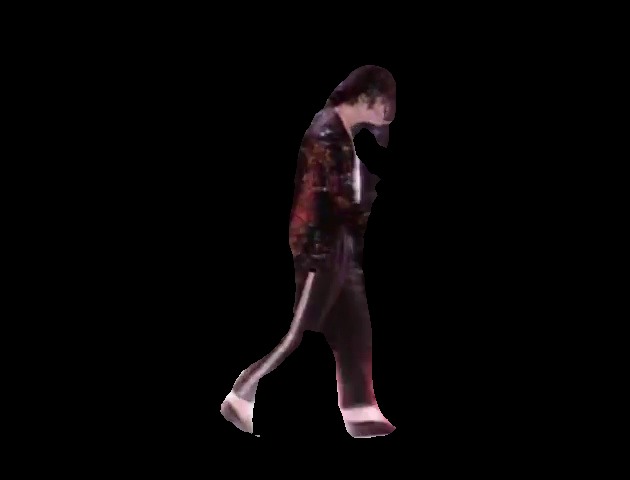

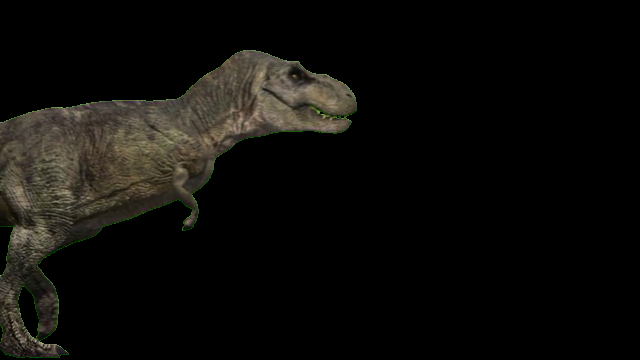

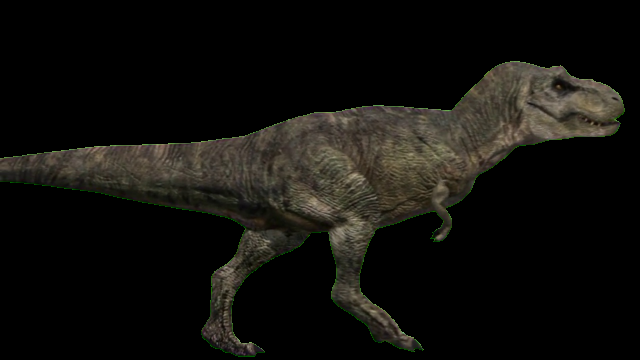

In [ ]:
#segmented MJ and dino
segmented_MJ[0].show()
segmented_MJ[48].show()

segmented_dino[0].show()
segmented_dino[48].show()


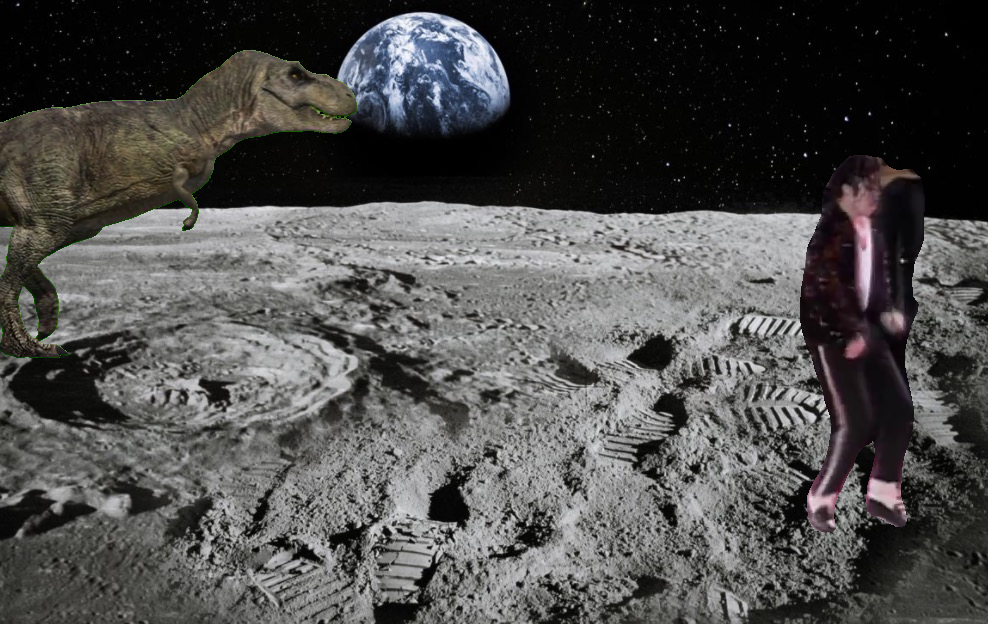

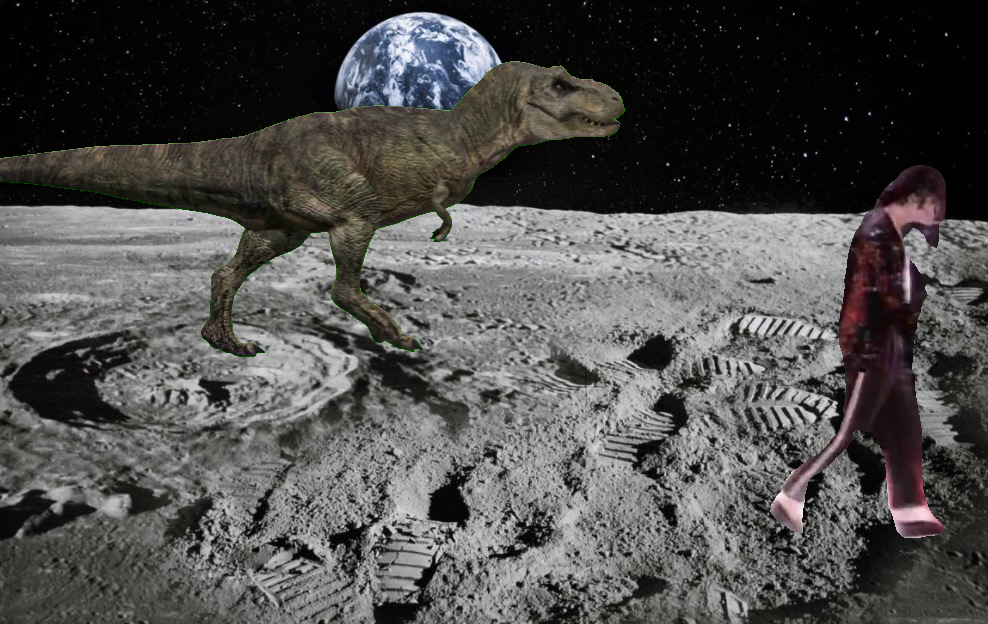

In [ ]:

Image.fromarray(video_frames[0].astype('uint8'), 'RGB').show()
Image.fromarray(video_frames[48].astype('uint8'), 'RGB').show()

In [ ]:
def image_seq_list_to_video(img_array, output_path='./video.mp4', fps=15.0):
    size = img_array[0].shape
    print(size)
    print("writing video...")
    writer = cv2.VideoWriter(output_path, 0, 1, (size[1], size[0]))
    for img in img_array:
        print(img.shape)
        writer.write(img)
    writer.release()
    print("saved video @ ", output_path)

In [ ]:
video_path = os.path.join("output", "moon_dino_MJ.mp4")
print(len(video_frames))
# image_seq_list_to_video(video_frames, video_path)
image_seq_to_video("data/my_data/moon_dino_MJ", video_path)

49
(988, 624)
writing video...
saved video @  output/moon_dino_MJ.mp4


#### Part 4 - Dry Questions
---

1. Explain the difference between ordinary segmentation and semantic segmentation. State an algorithm that performs standard segmentation and an algorithm that performs semantic segmentation.
2. Steve designed a segmentation algorithm, where the origin of the algorithm is always triangles. When he tried to segment a circle, he got the results below. Calculate the Intersection Over Union (IoU) in each case (it is enough to find an expression with the given parameters). 'o' indicates the center of the circle. The prediction of the algorithm is marked with a dashed line.

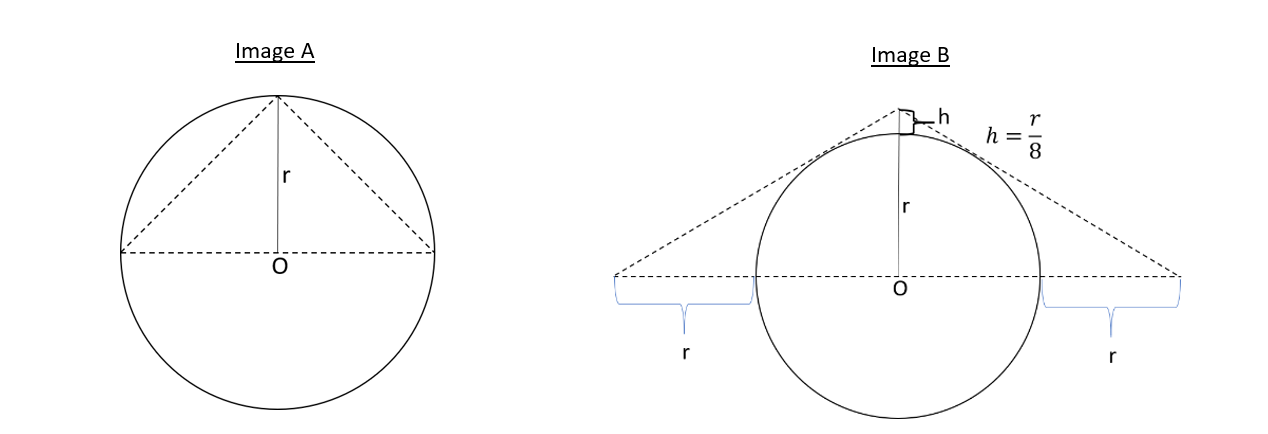



---
## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Images from <a href="http://www.image-net.org/">Imagenet</a>
* Videos from <a href="https://pixabay.com/videos/search/green%20screen/">Pixabay</a>
    * Dinosaur video from <a href="https://sites.google.com/a/sau17.net/modern-media/home/green-screen-animations">Modern Media</a>
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com